In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import scipy.io as sio
import importlib
import pathlib
import os
import sys
import pickle
import itertools 

sys.path.append(os.path.join('..'))

import sysid as sid
importlib.reload(sid)
import helper

<module 'sysid' from '/Users/felixfiedler/Documents/git_repos/2022_Robust_SPC/results/../sysid.py'>

# Meta analysis system identification of a mass-spring system

In [77]:
settings = {
    'N': 20,
    'T_ini': 3,
    'train_samples': 500,
    'test_samples': 300, 
}

Settings for the investigations.

In [90]:
base_sig_x=1e-1*np.ones(8)
base_sig_y=1e-1*np.ones(3)

sig_x_fac = np.array([.1, 1, 2])
sig_y_fac = np.array([.1, 1, 2])

investigations = list(itertools.product(sig_x_fac, sig_y_fac))


In [91]:
np.random.seed(99)

train_data = []

for sig_x_fac_i, sig_y_fac_i in investigations:
    sys_generator = sid.SystemGenerator(
        sys_type=sid.SystemType.TRIPLE_MASS_SPRING,
        sig_x=base_sig_x*sig_x_fac_i,
        sig_y=base_sig_y*sig_y_fac_i,
        dt=0.1,
    )

    data_gen_setup = sid.DataGeneratorSetup(
        T_ini=settings['T_ini'],
        N=settings['N'],
        n_samples=settings['train_samples'],
    )
    # Class that generates a pseudo-random input signal
    random_input = sid.RandomInput(n_u=2)
    
    # Generate data
    train_data.append(sid.DataGenerator(sys_generator, data_gen_setup, random_input))


test_data = []

# Generate the same input sequence for all test cases 
random_input_sequence = random_input.gen_sequence(settings['N']+settings['T_ini'])
# Input object that returns the same input sequence
sequence_input = sid.InputFromSequence(random_input_sequence)
# Initial state (identical for all test cases) 
x0_test = np.random.randn(8,1)
    
for sig_x_fac_i, sig_y_fac_i in investigations:
    # Test data
    test_data_setup = sid.DataGeneratorSetup(
        T_ini=data_gen_setup.T_ini,
        N=data_gen_setup.N,
        n_samples=settings['test_samples'],
    )

    sys_generator_wo_meas_noise = sid.SystemGenerator(
        sys_type=sys_generator.sys_type,
        sig_x=base_sig_x*sig_x_fac_i,
        sig_y=0,
        dt=sys_generator.dt,
        case_kwargs={'x0': x0_test}
    )

    # Generate test data
    test_data.append(sid.DataGenerator(sys_generator_wo_meas_noise, test_data_setup, sequence_input))

Text(0.5, 0.98, 'Test data - Same input sequence and without meas. noise')

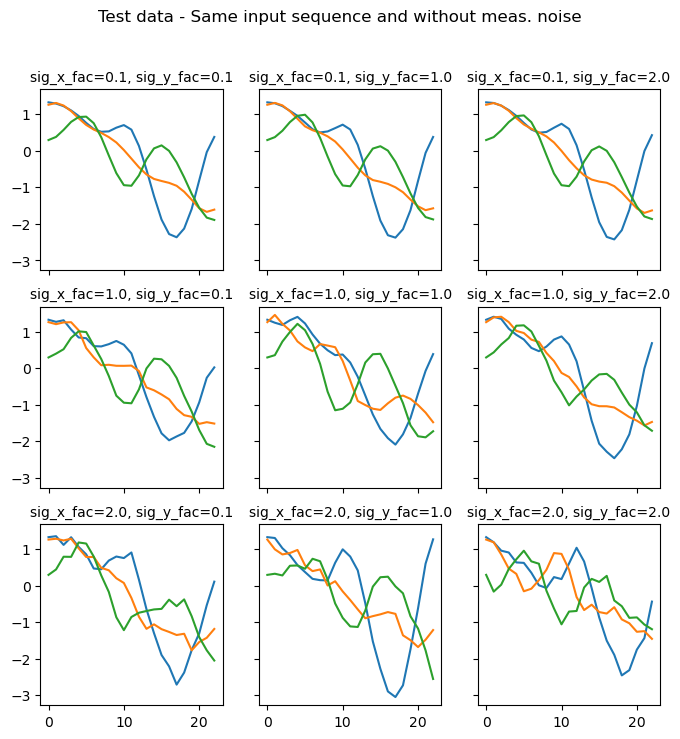

In [87]:
fig, ax = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True)

for i, test_data_i in enumerate(test_data):
    k,j = np.unravel_index(i, (3,3))
    
    ax[k,j].plot(test_data_i.sim_results[0].y)
    ax[k,j].set_title(f'sig_x_fac={investigations[i][0]}, sig_y_fac={investigations[i][1]}', fontsize=10)

fig.suptitle('Test data - Same input sequence and without meas. noise')


In [88]:
%%capture

results = []


for i, (train_data_i, test_data_i) in enumerate(zip(train_data, test_data)):
    if i==0:
        msm = sid.MultistepModel(estimate_covariance=True, scale_x=False, scale_y=False, add_bias=True)
        ssm = sid.StateSpaceModel(estimate_covariance=True, scale_x=False, scale_y=False, add_bias=True)
    msm.fit(train_data_i)
    ssm.fit(train_data_i)

    y_msm_pred, y_msm_pred_std = msm.predict(test_data_i.M[:,[0]].T, uncert_type="std", with_noise_variance=True)
    y_msm_pred = y_msm_pred.reshape(-1,test_data_i.n_y)
    y_msm_pred_std = y_msm_pred_std.reshape(-1,test_data_i.n_y)
    y_ssm_pred, y_ssm_pred_std = ssm.predict_sequence(test_data_i.M[:,[0]], with_noise_variance=True)

    msm_cov_final = msm.predict(test_data_i.M[:,[0]].T, uncert_type="cov", with_noise_variance=True)[1][-test_data_i.n_y:, -test_data_i.n_y:]

    results.append(
        {
            'y_msm_pred': y_msm_pred,
            'y_msm_pred_std': y_msm_pred_std,
            'y_ssm_pred': y_ssm_pred,
            'y_ssm_pred_std': y_ssm_pred_std,
            'msm_cov_final': msm_cov_final,
        }
    )

(-4.0, 4.0)

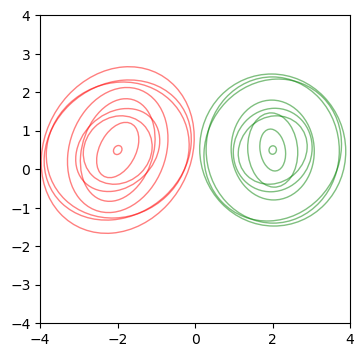

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharex=True, sharey=True)

for k in range(len(investigations)):
    cov = results[k]['msm_cov_final'][1:, 1:]
    helper.plot_cov_as_ellipse(-2, .5, cov, ax=ax, facecolor='none', edgecolor='r', linewidth=1, alpha=.5)
    cov = results[k]['msm_cov_final'][:2, :2]
    helper.plot_cov_as_ellipse(2, .5, cov, ax=ax, facecolor='none', edgecolor='g', linewidth=1, alpha=.5)

ax.set_xlim(-4,4)
ax.set_ylim(-4,4)

In [9]:
def get_plot(result, test_data):
    fig, ax = plt.subplots(test_data.n_y,1, sharex=True, figsize=(10,5))

    t_ini = test_data.setup.T_ini

    y_msm_pred = result['y_msm_pred']
    y_msm_pred_std = result['y_msm_pred_std']
    y_ssm_pred = result['y_ssm_pred']
    y_ssm_pred_std = result['y_ssm_pred_std']

    Y_pred = np.stack([sample.y[settings['T_ini']:] for sample in test_data.sim_results],axis=2)

    t = test_data.sim_results[0].time[settings['T_ini']:]
    for i in range(test_data.n_y):
        ax[i].plot(t, Y_pred[:,i,:], color='k',linewidth=1, alpha=0.05)

        ax[i].plot(t, y_ssm_pred[:,i],linewidth=2, label="SSM")
        ax[i].fill_between(t, y_ssm_pred[:,i]-3*y_ssm_pred_std[:,i], y_ssm_pred[:,i]+3*y_ssm_pred_std[:,i], alpha=0.3)

        ax[i].plot(t, y_msm_pred[:,i], '--', linewidth=2, label="MSM")
        ax[i].fill_between(t, y_msm_pred[:,i]-3*y_msm_pred_std[:,i], y_msm_pred[:,i]+3*y_msm_pred_std[:,i], alpha=0.3)

    ax[0].plot([],[], color='k', linewidth=1, alpha=0.2, label="Samples")

    ax[0].legend()

    return fig, ax

Text(0.5, 0.98, '$\\sigma_x$=2.0, $\\sigma_y$=1.0')

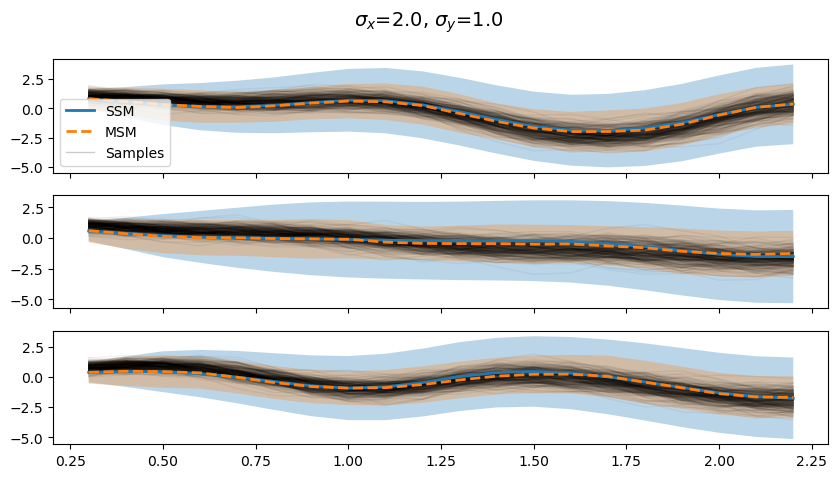

In [10]:
plot_case = 7

fig, ax = get_plot(results[plot_case], test_data[plot_case])
fig.suptitle(f'$\sigma_x$={investigations[plot_case][0]}, $\sigma_y$={investigations[plot_case][1]}', fontsize=14)

In [11]:
def get_normalized_distance(Y_true, y_pred, y_pred_std):
    norm_dist = np.abs(Y_true-np.atleast_3d(y_pred))/np.atleast_3d(y_pred_std)
    return norm_dist

def get_stats(Y_true, y_pred, y_pred_std):
    norm_dist = get_normalized_distance(Y_true, y_pred, y_pred_std)
    in_three_sigma = np.sum(norm_dist < 3)/np.prod(norm_dist.shape)
    # three_sigma_percentile = np.percentile(norm_dist, 99.73, axis=[0,1,2])
    three_sigma_percentile = np.mean(np.percentile(norm_dist, 99.73, axis=[1,2]))
    mse = np.mean((Y_true-np.atleast_3d(y_pred))**2)

    return in_three_sigma, three_sigma_percentile, mse

In [12]:
results_post_proc = {
    'msm': {
        'Frac. in 3 sigma': [],
        '99.73 percentile': [],
        'mse': [],
    },
    'ssm': {
        'Frac. in 3 sigma': [],
        '99.73 percentile': [],
        'mse': [],
    },
}

for i, (test_data_i, results_i) in enumerate(zip(test_data, results)):
    Y_pred = np.stack([sample.y[settings['T_ini']:] for sample in test_data_i.sim_results],axis=2)

    stats_msm = get_stats(Y_pred, results_i['y_msm_pred'], results_i['y_msm_pred_std'])
    stats_ssm = get_stats(Y_pred, results_i['y_ssm_pred'], results_i['y_ssm_pred_std'])

    results_post_proc['msm']['Frac. in 3 sigma'].append(stats_msm[0])
    results_post_proc['msm']['99.73 percentile'].append(stats_msm[1])
    results_post_proc['msm']['mse'].append(stats_msm[2])
    results_post_proc['ssm']['Frac. in 3 sigma'].append(stats_ssm[0])
    results_post_proc['ssm']['99.73 percentile'].append(stats_ssm[1])
    results_post_proc['ssm']['mse'].append(stats_ssm[2])
    


In [13]:
d1 = pd.DataFrame(results_post_proc['msm'], index=investigations)
d2 = pd.DataFrame(results_post_proc['ssm'], index=investigations)

df = pd.concat([d1,d2], keys=['msm', 'ssm'], axis=1)

df

msm                                         ssm  \
           Frac. in 3 sigma 99.73 percentile       mse Frac. in 3 sigma   
(0.1, 0.1)         0.999722         2.360564  0.000601         1.000000   
(0.1, 1.0)         1.000000         0.617752  0.001452         1.000000   
(0.1, 2.0)         1.000000         0.396919  0.003082         1.000000   
(1.0, 0.1)         0.997000         2.907736  0.062630         0.998111   
(1.0, 1.0)         0.999889         2.348255  0.061105         1.000000   
(1.0, 2.0)         1.000000         1.893111  0.071729         1.000000   
(2.0, 0.1)         0.998333         2.818356  0.240096         0.998167   
(2.0, 1.0)         0.995333         3.087135  0.315776         0.997000   
(2.0, 2.0)         0.996778         2.967619  0.400767         0.998889   

                                       
           99.73 percentile       mse  
(0.1, 0.1)         1.129959  0.000634  
(0.1, 1.0)         0.201958  0.002556  
(0.1, 2.0)         0.207529  0.020195  
(1.0, 0.1)         1.877501  0.062337  
(1.0, 1.0)         1.229993  0.063635  
(1.0, 2.0)         0.845274  0.086479  
(2.0, 0.1)         1.940038  0.252456  
(2.0, 1.0)         1.875913  0.344659  
(2.0, 2.0)         1.572982  0.404157

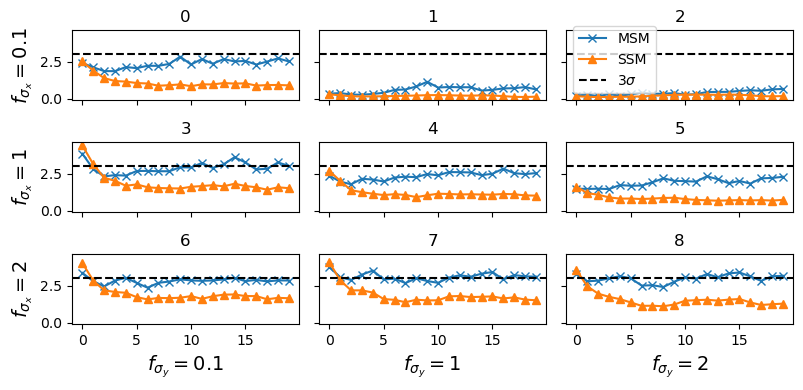

In [43]:
fig, ax = plt.subplots(3, 3, figsize=(8, 4), sharex=True, sharey=True)

for i, (test_data_i, results_i) in enumerate(zip(test_data, results)):
    k,j = np.unravel_index(i, (3,3))
    
    Y_pred = np.stack([sample.y[settings['T_ini']:] for sample in test_data_i.sim_results],axis=2)
    norm_dist_msm = get_normalized_distance(Y_pred, results_i['y_msm_pred'], results_i['y_msm_pred_std'])
    norm_dist_ssm = get_normalized_distance(Y_pred, results_i['y_ssm_pred'], results_i['y_ssm_pred_std'])

    three_sigma_percentile_msm = np.percentile(norm_dist_msm, 99.73, axis=[1,2])
    three_sigma_percentile_ssm = np.percentile(norm_dist_ssm, 99.73, axis=[1,2])
    
    ax[k,j].plot(three_sigma_percentile_msm, '-x', label='MSM')
    ax[k,j].plot(three_sigma_percentile_ssm, '-^', label='SSM')    
    ax[k,j].axhline(3, color='k', linestyle='--', label='$3\sigma$')

    ax[k,j].set_title(f'{i}')


ax[0,0].set_ylabel('$f_{\sigma_x} = 0.1$', fontsize=14)
ax[1,0].set_ylabel('$f_{\sigma_x} = 1$', fontsize=14)
ax[2,0].set_ylabel('$f_{\sigma_x} = 2$', fontsize=14)

ax[2,0].set_xlabel('$f_{\sigma_y} = 0.1$', fontsize=14)
ax[2,1].set_xlabel('$f_{\sigma_y} = 1$', fontsize=14)
ax[2,2].set_xlabel('$f_{\sigma_y} = 2$', fontsize=14)

ax[0,2].legend()
fig.tight_layout()

## Export model

In [46]:
%%capture

export_id = 4

train_data_i = train_data[export_id]
msm = sid.MultistepModel(estimate_covariance=True, scale_x=False, scale_y=False, add_bias=True)
ssm = sid.StateSpaceModel(estimate_covariance=True, scale_x=False, scale_y=False, add_bias=True)
msm.fit(train_data_i)
ssm.fit(train_data_i)

sig_x_fac_i, sig_y_fac_i = investigations[export_id]
sigma_x=base_sig_x*sig_x_fac_i,
sigma_y=base_sig_y*sig_y_fac_i


In [48]:
result_dir = os.path.join('sid_results')
save_name = "mass_spring_prediction_models.pkl"
save_name = os.path.join(result_dir, save_name)

pathlib.Path(result_dir).mkdir(parents=True, exist_ok=True)

with open(save_name, "wb") as f:
    res = {'msm': msm, 'ssm': ssm, 'sigma_x': sigma_x, 'sigma_y': sigma_y}
    pickle.dump(res, f)

Check if loading works

In [49]:
with open(save_name, "rb") as f:
    res = pickle.load(f)